In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch.nn import ReLU
from torch.nn import Linear
from torch.nn import Module
from torch.nn import MSELoss
from torch.nn import Sequential
from torch.optim import SGD
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# Dataset
class FnDataset(Dataset):
    def __init__(self, fn, n_samples, x_min, x_max):
        x = np.random.uniform(x_min, x_max, n_samples)
        y = fn(x)
        
        self.n = n_samples
        self.x = torch.unsqueeze(torch.FloatTensor(x), 1)
        self.y = torch.unsqueeze(torch.FloatTensor(y), 1)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        return (self.x[idx], self.y[idx])

In [3]:
# Model
class MLP(Module):
    def __init__(self, n_in, n_out):
        super(MLP, self).__init__()
        self.hidden1    = Linear(n_in, 64)
        self.hidden2    = Linear(64, 64)
        self.hidden3    = Linear(64, 64)
        self.hidden4    = Linear(64, 64)
        self.hidden5    = Linear(64, 1)
        self.non_linear = ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.non_linear(x)
        x = self.hidden2(x)
        x = self.non_linear(x)
        x = self.hidden3(x)
        x = self.non_linear(x)
        x = self.hidden4(x)
        x = self.non_linear(x)
        x = self.hidden5(x)
        
        return x

In [4]:
# Training function
def train(dataloader, model, loss, optimizer):
    model.train()
    for x, y in dataloader:
        # Compute predictions
        p = model(x)
        l = loss(p, y)
        
        # Backpropagation
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

In [5]:
# Training function
def validate(dataloader, model, loss):
    validation_loss = []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            # Compute predictions
            p = model(x)
            l = loss(p, y)

            validation_loss.append(l.item())
        
    return np.mean(validation_loss)

In [6]:
def fn(x):
    return x

n = 10000
a = -3
b = 3

training_dataset = FnDataset(fn, 10000, a, b)
training_dataloader = DataLoader(training_dataset, batch_size=100, shuffle=True)

validation_dataset = FnDataset(fn, 1000, a, b)
validation_dataloader = DataLoader(validation_dataset, batch_size=100, shuffle=True)

In [7]:
model = MLP(1, 1)
loss = MSELoss()
optimizer = SGD(model.parameters(), lr=1.0e-3)

In [8]:
validation_loss = []

In [9]:
# Early stopping
lowest_loss   = 1000
patience      = 10
trigger_times = 0
best_model    = copy.deepcopy(model.state_dict())

# Training
epochs = 200
for _ in tqdm(range(epochs)):    
    # Train model
    train(training_dataloader, model, loss, optimizer)
    
    # Validate model
    current_loss = validate(validation_dataloader, model, loss)
    validation_loss.append(current_loss)
    
    # Early stopping
    if current_loss > lowest_loss:
        trigger_times += 1
        if trigger_times >= patience:
            break
    else:
        trigger_times = 0
        lowest_loss = current_loss
        best_model = copy.deepcopy(model.state_dict())
        
# Save current model
current_model = copy.deepcopy(model.state_dict())

# Load model with the lowest loss
model.load_state_dict(best_model)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.07it/s]


<All keys matched successfully>

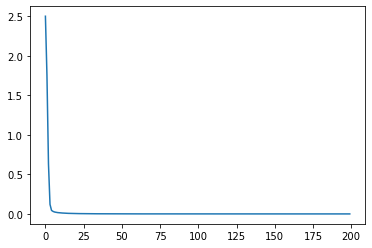

In [10]:
plt.plot(validation_loss)

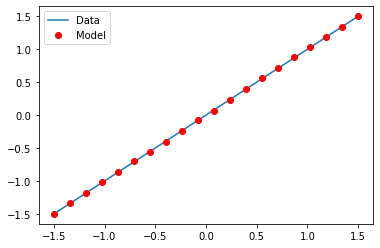

In [11]:
x = np.linspace(a/2.0, b/2.0, n)
y = fn(x)

model.eval()
x_model = torch.from_numpy(np.linspace(a/2.0, b/2.0, 20))
x_model = x_model.type(torch.float32)
x_model = torch.unsqueeze(x_model, 1)
y_model = model(x_model)

x_pred = x_model.detach().numpy()
y_pred = y_model.detach().numpy()

plt.plot(x, y, label="Data")
plt.plot(x_pred, y_pred, "ro", label="Model")
plt.legend()

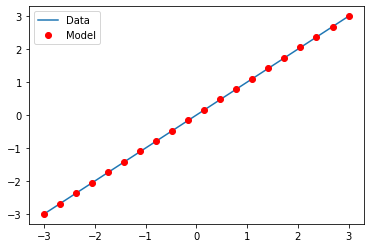

In [12]:
x = np.linspace(a, b, n)
y = fn(x)

model.eval()
x_model = torch.from_numpy(np.linspace(a, b, 20))
x_model = x_model.type(torch.float32)
x_model = torch.unsqueeze(x_model, 1)
y_model = model(x_model)

x_pred = x_model.detach().numpy()
y_pred = y_model.detach().numpy()

plt.plot(x, y, label="Data")
plt.plot(x_pred, y_pred, "ro", label="Model")
plt.legend()

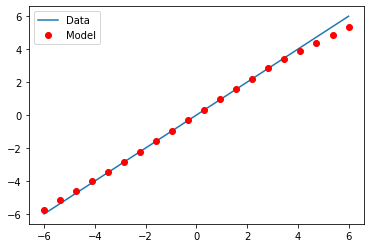

In [13]:
x = np.linspace(2.0*a, 2.0*b, n)
y = fn(x)

model.eval()
x_model = torch.from_numpy(np.linspace(2.0*a, 2.0*b, 20))
x_model = x_model.type(torch.float32)
x_model = torch.unsqueeze(x_model, 1)
y_model = model(x_model)

x_pred = x_model.detach().numpy()
y_pred = y_model.detach().numpy()

plt.plot(x, y, label="Data")
plt.plot(x_pred, y_pred, "ro", label="Model")
plt.legend()